# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

Looking at the Starbucks data, these are the questions came in my mind -  
  
Q.1 What offers are popular among all of the users?  
Q.2 Which group of people is more likely to use the offer?  
Q.3 Which type of offer opt without even noticing the offer recieved?    
  
There can be many other questions which can come to our mind and everyone has diffrent set of mind. 
This is the important stage of CRISP-DM which is know as Business Understanding.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

% matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding

## i) Offer Portfolio 

In [3]:
# check the first 5 portfolio
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There is no null values, hence we don't need to handle the missing data in data preprocessing.

In [5]:
# check all the offer_type
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
# check unique offers
portfolio.id.unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [7]:
# check unique offers count
portfolio.id.nunique()

10

In [8]:
# check the offer_type distribution among unique offers
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

We see that there are 3 unique types of offer has been provided by starbucks and found that 10 unique offers has been provided and the distribution of offer is like 4 offers with bogo and discount and rest 2 is for informational.

## ii) Demographic 

In [9]:
# check the first 5 demographic data from profile.json
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


From the first 5 lines the age column contains some values that does not make sense (e.g. 118)

In [10]:
# check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There are null values for  gender and income for same row. 

In [11]:
# see all the diffrent ages in dataset
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

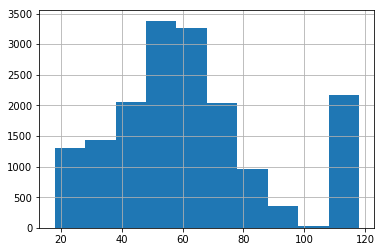

In [12]:
# check distribution of age column
profile.age.hist()

We see the count of age 118 is 2175 and similar count we saw for null values of income and gender. Now, let's see what is the income and gender is for profile age 118. 118 is an outlier we can analyze from the profile age histogram pictorial. 

In [13]:
# check first 5 rows where age of profile is 118.
profile[profile.age == 118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


From top 5 lines, we see that all the age of 118 profile is not having the correct details in gender and income as well. 

In our Udacity program, we have learned that if all the columns of one row is either invalid value i.e age (able to analyze from histogram visualization) or missing value i.e gender and age, this means that we should drop those row according to handle missing data process. This we'll handle in Data Preprocessing step.

In [14]:
#check how many unique people are in dataset
profile.nunique()

age                    85
became_member_on     1716
gender                  3
id                  17000
income                 91
dtype: int64

Profile is having id field as unique column and see that there are 17000 unique entries for profile.

## iii) Transactional Record

In [15]:
# check the first 5 rows of transactional record using transcript.json file
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
# check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values, so the good news we don't need to handle missing data in data preprocessing steps.

In [17]:
# check the unique values of event
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [18]:
# check the transactional record count for unique person
transcript.person.nunique()

17000

We can see that the unique no of Profile is the same as the transactional record for unique person and we suspect that there is no ambiguity in trasactional records. Means all the transactions has been made by the profile which exist in our system.

Expand the value column of transcript dataset.

# Data Preprocessing

## i) Remove all the profile which is having age 118 and income & gender as a null value for same row. 

Due to the incomplete information, they are significantly less likely to use our offer. I decided to drop them for now. However, I made the assumption that they are likely to spend less money as well due to the low degree of participation, without analysising the amount of transaction that they made.

In [19]:
# drop null values as we have analyzed that need to drop rows for that which is having 
# gender and income null and age is invalid value 118.

copy_profile = profile[profile['gender'].notnull()].copy()
copy_profile.drop('id', axis=1, inplace=True)
copy_profile.head()

,age,became_member_on,gender,income
1,55,20170715,F,112000.0
3,75,20170509,F,100000.0
5,68,20180426,M,70000.0
8,65,20180209,M,53000.0
12,58,20171111,M,51000.0


##  ii) Expand the transcript value column

In [20]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appears as though the offer id column ended up being duplicates so we have to clean it up further to ensure there is only one offer id column.

In [21]:
# create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

In [22]:
# drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [23]:
# we have extracted value column information, so we can drop that column as well
transcript.drop(['value'],axis=1,inplace=True)

In [24]:
transcript.amount.fillna(value=0, inplace=True)

In [25]:
transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## iii) Merge Profile and Transcript Datasets

In [26]:
#merge the two dataset
df = transcript.merge(profile, left_on='person', right_on='id', how='outer')

In [27]:
df.head()

,event,person,time,amount,reward,offer_id,age,became_member_on,gender,id,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.00,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


### iv) correct data types and formats

In [28]:
def format_df(df):
    
    #change became_member_on to datetime formate
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    # create a new column that has the year which customers become members
    df['year'] = df['became_member_on'].apply(lambda x: str(x)[:4])
    
    #change the time in hours to days, rounding up
    df['days'] = df['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
    df.drop(['id', 'reward'],axis=1,inplace=True)
    df = df.reset_index(drop=True)
    
    return df

In [29]:
df = format_df(df)
df.head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,75,2017-05-09,F,100000.0,2017,6
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,6
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,75,2017-05-09,F,100000.0,2017,6


In [30]:
# see all the columns for merge dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
amount              306534 non-null float64
offer_id            167581 non-null object
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
year                306534 non-null object
days                306534 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 25.7+ MB


## v) Merge Portfolio Dataset

In [31]:
#merge the portfolio dataset as well
final_df = df.merge(portfolio, left_on='offer_id', right_on='id', how='outer')
final_df.drop(['id'], axis=1, inplace=True) #drop the repeated column
final_df.head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,days,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,0,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,1,"[web, email, mobile]",5.0,7.0,bogo,5.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,6,"[web, email, mobile]",5.0,7.0,bogo,5.0
3,offer received,e2127556f4f64592b11af22de27a7932,408,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,17,"[web, email, mobile]",5.0,7.0,bogo,5.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,18,"[web, email, mobile]",5.0,7.0,bogo,5.0


In [32]:
# see all the columns for final merge data set
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 16 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
amount              306534 non-null float64
offer_id            167581 non-null object
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
year                306534 non-null object
days                306534 non-null int64
channels            167581 non-null object
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 39.8+ MB


## vi) Encoding Categorical Data

We see that event, gender, year, channels and offer_type are those catgeorical data which are having some common values for all the dataset and person, offer_id are those type of values which are completely unique for each row, so we won't encode those data. Let's take a close value of all values for event, gender, year, channels and offer_type.

In [33]:
# check gender unique values
final_df.gender.unique()

array(['F', 'M', None, 'O'], dtype=object)

In [34]:
# check event unique values
final_df.event.unique()

array(['offer received', 'offer viewed', 'offer completed', 'transaction'], dtype=object)

In [35]:
# check year unique values
final_df.year.unique()

array(['2017', '2018', '2015', '2016', '2014', '2013'], dtype=object)

In [36]:
# check offer_type unique values
final_df.offer_type.unique()

array(['bogo', nan, 'informational', 'discount'], dtype=object)

In [37]:
def encoding(df, cols):
    """
    input: 
    df: the dataframe
    cols: a list of cols that are categorical variabls and want to turn into numerical.
    
    output:
    dataframe with old columns + additional columns that turned categorial variables into numbers.
    The numbers only indicates different categories, not orders.
    """
    for col in cols:
        #get all the unique categories in the column
        array = df[col].unique()
        
        #get the numbers of categories
        value_nums = len(array)
        
        #create new column
        df[col+'_id'] = df[col]

        for i in range(value_nums):
            #replace the variable with a number in the newly created column
            df[col+'_id'] = np.where(df[col]==array[i] , i, df[col+'_id'])
    
    return df

In [128]:
def encode_allcat(df, cols):
    """
    df: the df you want to clean
    cols: the cols that can be cleaned by using cate2num
    
    output:
    a dataframe with all orginal columns + new columns that turned the following categorical columns into
    numerical values.
    
    columns are ['gender', 'event', 'offer_type', 'year', channels']
    
    """
    #normal cat variables to numbers
    encoded_df = encoding(df, cols)
    
    #years
    years = df['year'].unique()
    year_sorted = [];
    for x in list(years):
        if type(x) is str:
            year_sorted.append(int(x))
        else:
            pass
    year_sorted = sorted(year_sorted)
    #year_sorted = sorted([int(x) for x in list(years)])
    encoded_df['year_id'] = df['year']
    for i in range(len(year_sorted)):
        encoded_df['year_id'] = np.where(encoded_df['year_id']==str(year_sorted[i]) , i, encoded_df['year_id'])

    #channelId
    col = 'channels'
    channelTye_id = df[col].copy()
    length = len(df)
    
    for x in range(length):
        if df[col][x] == ['web', 'email', 'mobile', 'social']:
            channelTye_id[x] = 3
        elif df[col][x] == ['web', 'email', 'mobile']:
            channelTye_id[x] = 2
        elif df[col][x] == ['email', 'mobile', 'social']:
            channelTye_id[x] = 1
        elif df[col][x] == ['web', 'email']:
            channelTye_id[x] = 0
            
    encoded_df['channelTye_id'] = channelTye_id

    return encoded_df

In [129]:
# encode categorical values to numeric
encoded_df = encode_allcat(final_df, ['gender', 'event', 'offer_type'])

encoded_df.head()


,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,0,0,4,2,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,1,0,4,2,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,2,0,4,2,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,0,0,5,2,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,1,0,5,2,1


These are the encoded values we have set to respective columns:  
event encoded data saved to event_id  
    * 'offer received' - 0  
    * 'offer viewed' - 1  
    * 'offer completed' - 2  
    * 'transaction' - 3  
      
gender encoded data saved to gender_id (There is some NONE values) 
    * F - 0  
    * M - 1  
    * O - 3  
      
channels encoded data saved to channelTye_id  
    * [web, email] - 0  
    * [email, mobile, social] - 1  
    * [web, email, mobile] - 2  
    * [web, email, mobile, social] - 3  
      
offer_type encoded data saved to offer_type_id  (There is some nan values)
    * 'bogo' - 0   
    * 'informational' - 2  
    * 'discount' - 3  
      
year encoded data saved to year_id  
    * '2013' - 0  
    * '2014' - 1  
    * '2015' - 2  
    * '2016' - 3  
    * '2017' - 4  
    * '2018' - 5  


In [130]:
encoded_df.offer_type_id.unique()

array([0, nan, 2, 3], dtype=object)

In [131]:
#df with only offer records
offer_df = encoded_df[encoded_df['offer_id'].notnull()]

offer_df.head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,0,0,4,2,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,1,0,4,2,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,2,0,4,2,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,0,0,5,2,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,1,0,5,2,1


In [132]:
offer_df[offer_df['offer_type'] == 'informational'].head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
155155,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,0.0,5a8bc65990b245e5a138643cd4eb9837,75,2017-05-09,F,100000.0,2017,...,0.0,3.0,informational,0.0,0,0,2,4,1,1
155156,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0.0,5a8bc65990b245e5a138643cd4eb9837,75,2017-05-09,F,100000.0,2017,...,0.0,3.0,informational,0.0,0,1,2,4,1,1
155157,offer received,a03223e636434f42ac4c3df47e8bac43,408,0.0,5a8bc65990b245e5a138643cd4eb9837,118,2017-08-04,None,NaN,2017,...,0.0,3.0,informational,0.0,None,0,2,4,1,1
155158,offer received,aa4862eba776480b8bb9c68455b8c2e1,336,0.0,5a8bc65990b245e5a138643cd4eb9837,61,2017-09-11,F,57000.0,2017,...,0.0,3.0,informational,0.0,0,0,2,4,1,1
155159,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,336,0.0,5a8bc65990b245e5a138643cd4eb9837,61,2017-09-11,F,57000.0,2017,...,0.0,3.0,informational,0.0,0,1,2,4,1,1


In [133]:
# df with only bogo and discount offer type
# considering 0 for bogo and 3 for discount
offer_bogo_discount = encoded_df.loc[(encoded_df['offer_type_id']==0) | (encoded_df['offer_type_id']==3)]
offer_bogo_discount.head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,0,0,4,2,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,1,0,4,2,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,2017,...,5.0,7.0,bogo,5.0,0,2,0,4,2,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,0,0,5,2,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,68,2018-04-26,M,70000.0,2018,...,5.0,7.0,bogo,5.0,1,1,0,5,2,1


# Data Analysis

These are the questions which we are going to analyze in this section - 

Q.1 What offers are popular among all of the users?  
Q.2 Which group of people is more likely to use the offer?   
Q.3 Which type of offer opt without even noticing the offer recieved?  

## Q.1 What offers are popular among all of the users?

In [134]:
print('The total counts of different events for BOGO offer is')
print(offer_df[offer_df["offer_type_id"]==0]['event'].value_counts())

print('\n\nThe total counts of different events for discount offer is')
print(offer_df[offer_df["offer_type_id"]==3]['event'].value_counts())

print('\n\nThe total counts of different events for informational offer is')
print(offer_df[offer_df["offer_type_id"]==2]['event'].value_counts())

The total counts of different events for BOGO offer is
offer received     30499
offer viewed       25449
offer completed    15669
Name: event, dtype: int64


The total counts of different events for discount offer is
offer received     30543
offer viewed       21445
offer completed    17910
Name: event, dtype: int64


The total counts of different events for informational offer is
offer received    15235
offer viewed      10831
Name: event, dtype: int64


There is no offer completed by informational offer, so we'll analyze the comparison data in between bogo and discount offer.

Text(0.5,1,'Total counts of BOGO offer vs. discount offer\n')

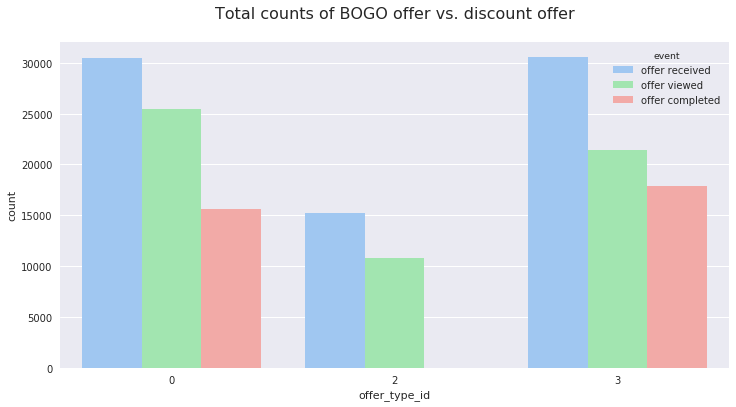

In [135]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type_id", hue="event", data=offer_df, palette="pastel")
plt.title("Total counts of BOGO offer vs. discount offer\n", fontsize=16)

In [136]:
#dataframe with only bogo offer
bogo = offer_df[offer_df['offer_type_id']==0]
#dataframe with only discount offer
discount = offer_df[offer_df['offer_type_id']==3]

def event_counts(df):
    """
    output:
    returns the counts of each individual event
    
    for example:
    There are 3 different events in this dataset - offer completed/viewed/received.
    The result will return 3 numbers that are the total counts of each of these events.
    """
    events = df['event_id'].unique()
    counts = []
    for event in events:
        count = len(df[df['event_id'] == event])
        yield count

In [137]:
#event counts of BOGO offer
bogo0, bogo1, bogo2 = event_counts(bogo)

#event counts of discount offer
discount0, discount1, discount2 = event_counts(discount)

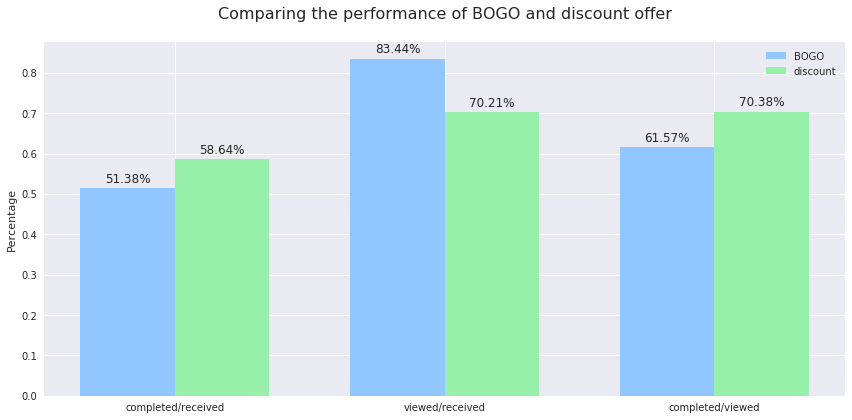

In [138]:
"""
BOGO and discount offers' performances in terms of percentage
"""

labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo2/bogo0, bogo1/bogo0, bogo2/bogo1]
discount_performance = [discount2/discount0, discount1/discount0, discount2/bogo1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Analysis
Discount offer is more popular because not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers.

## Q.2 Which group of people is more likely to use the offer?  

In [139]:
offer_df['interacted'] = 1

person_offer = offer_df.groupby(['person', 'days','event'])['interacted'].max().unstack(fill_value=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'count')

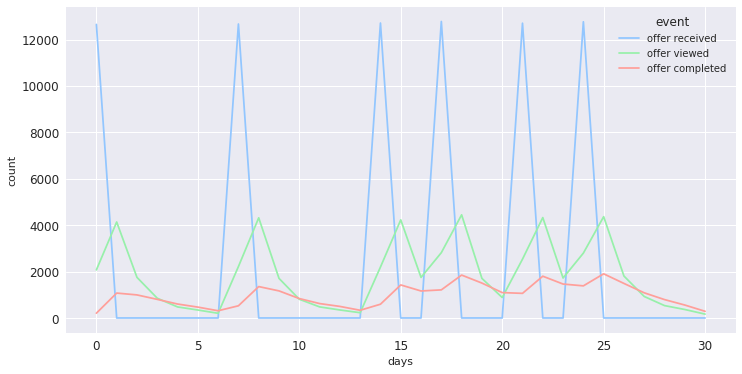

In [140]:
events = list(offer_df['event'].unique())
ax = person_offer.groupby('days')[events].sum().plot(figsize=(12,6), fontsize=12)
ax.set_xlabel = ('days')
ax.set_ylabel("count")

### Analysis
The peak of offer completed is slightly before offer viewed in the first 5 days of experiment time. 

They sync better as time goes by indicating that majority of the people still used the offer with conscious.

In [141]:
#select the first 2 interactions a person had with an offer
time_0 = offer_df.sort_values('time').groupby(['person', 'offer_id']).tail(2)
time_0.head()

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
271723,offer received,a7d1c458a2844d138ecd7f2b189c22fe,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,41,2016-02-05,F,64000.0,2016,...,10.0,5.0,bogo,10.0,0,0,0,3,3,1
271731,offer received,7be5dd52d7d540429299a9ee454774e7,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,47,2017-03-26,M,71000.0,2017,...,10.0,5.0,bogo,10.0,1,0,0,4,3,1
157218,offer received,591b17b5a24a44f7a23bd2296e46e0c4,0,0.0,5a8bc65990b245e5a138643cd4eb9837,45,2013-09-09,F,82000.0,2013,...,0.0,3.0,informational,0.0,0,0,2,0,1,1
271732,offer viewed,7be5dd52d7d540429299a9ee454774e7,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,47,2017-03-26,M,71000.0,2017,...,10.0,5.0,bogo,10.0,1,1,0,4,3,1
157211,offer received,8ae377b128c54a469964ac5df53144b8,0,0.0,5a8bc65990b245e5a138643cd4eb9837,52,2018-07-14,F,63000.0,2018,...,0.0,3.0,informational,0.0,0,0,2,5,1,1


In [142]:
#demonstration of the dataset for 1 user
time_0[time_0['person'] == 'a7d1c458a2844d138ecd7f2b189c22fe']

,event,person,time,amount,offer_id,age,became_member_on,gender,income,year,...,difficulty,duration,offer_type,reward,gender_id,event_id,offer_type_id,year_id,channelTye_id,interacted
271723,offer received,a7d1c458a2844d138ecd7f2b189c22fe,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,41,2016-02-05,F,64000.0,2016,...,10.0,5.0,bogo,10.0,0,0,0,3,3,1
271724,offer viewed,a7d1c458a2844d138ecd7f2b189c22fe,30,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,41,2016-02-05,F,64000.0,2016,...,10.0,5.0,bogo,10.0,0,1,0,3,3,1
222707,offer received,a7d1c458a2844d138ecd7f2b189c22fe,408,0.0,3f207df678b143eea3cee63160fa8bed,41,2016-02-05,F,64000.0,2016,...,0.0,4.0,informational,0.0,0,0,2,3,2,1
251880,offer viewed,a7d1c458a2844d138ecd7f2b189c22fe,516,0.0,fafdcd668e3743c1bb461111dcafc2a4,41,2016-02-05,F,64000.0,2016,...,10.0,10.0,discount,2.0,0,1,3,3,3,1
251881,offer completed,a7d1c458a2844d138ecd7f2b189c22fe,552,0.0,fafdcd668e3743c1bb461111dcafc2a4,41,2016-02-05,F,64000.0,2016,...,10.0,10.0,discount,2.0,0,2,3,3,3,1


In [143]:
#dataset with users first interaction
#first_event= time_0.sort_values('time').groupby(['person', 'offer_id']).min()
#first_event.to_pickle("./firstEvent.pkl")

In [144]:
#dataset with users second interaction
#second_event= time_0.sort_values('time').groupby(['person', 'offer_id']).max()
#second_event.to_pickle("./secondEvent.pkl")

In [145]:
first_event = pd.read_pickle("./firstEvent.pkl")
second_event= pd.read_pickle("./secondEvent.pkl")

In [146]:
#we only want to examine the users who received an offer and compelted it without viewing
event1 = first_event[first_event['event']=='offer received']
event2 = second_event[second_event['event']=='offer completed']

#a list of [person, offer id] whose first intereaction with the offer was 'offer received'
lst1 = []

#a list of [person, offer id] whose second intereaction with the offer was 'offer completed'
lst2 = [] 

for x in range(len(event1)):
    person = event1.index[x]
    lst1.append(person)

for y in range(len(event2)):
    person = event2.index[y]
    lst2.append(person)

print(lst1[0], lst2[0])

('0009655768c64bdeb2e877511632db8f', '3f207df678b143eea3cee63160fa8bed') ('01925607d99c460996c281f17cdbb9e2', '4d5c57ea9a6940dd891ad53e9dbe8da0')


In [147]:
#take out only the person ids
person1 = [lst1[x][0] for x in range(len(lst1))]
person2 = [lst2[x][0] for x in range(len(lst2))]

#found the people that exist in both lists
c = Counter(person1) & Counter(person2)
#a list of people whom completed an offer without viewing it
person_list = list(c.keys())

In [148]:
#we want to study these people. Therefore, we label them in the profile dataset
profile['problem'] = np.where(profile.id.isin(person_list), 1, 0)

profile.head()

,age,became_member_on,gender,id,income,problem
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,0


In [149]:
def clean_profile(df):
    clean_df = df[df['gender'].notnull()].copy() #drop null values
    
    #change became_member_on to datetime formate
    clean_df['became_member_on'] = pd.to_datetime(clean_df['became_member_on'], format='%Y%m%d')
    # create a new column that has the year which customers become members
    clean_df['year'] = clean_df['became_member_on'].apply(lambda x: str(x)[:4])

    return clean_df
    

clean_profile = clean_profile(profile)
clean_profile.head()

,age,became_member_on,gender,id,income,problem,year
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,2017
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,2018
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,2018
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,2017


In [150]:
def boxplots(df, variables, hue, n_rows=None, n_cols=None):
    '''Draw boxplots to examine the churn behavior of each continuous variable. 

    Args:
    variables: list. A list of variables that you would like to examine
    n_rows, n_cols: int. 
    hue: Because the context here is a churn analysis, so I set the default to "Churn". 
    
    Returns:
    boxplots of all the variables that were passed in the format of that you specify. 
    '''
    fig=plt.figure(figsize=(12,6))
    sns.set(palette='pastel')
    for i, var in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        sns.boxplot(y=var, x=hue, hue=hue, data=df, ax=ax).set_title(var)
    plt.show()


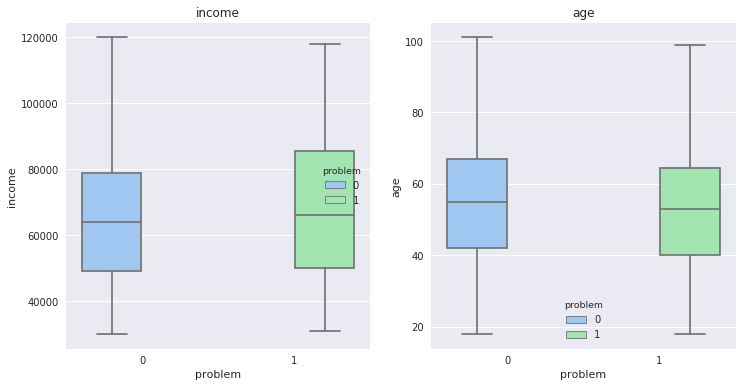

In [151]:
var=['income', 'age']
boxplots(df=clean_profile, variables=var, hue="problem", n_rows=1, n_cols=2,)

In [152]:
problem_df = clean_profile[clean_profile['problem']==1]
no_problem = clean_profile[clean_profile['problem']==0]

Text(0,1,'Comparing the propotion of joining year b/w the problematic profiles and the rest\n')

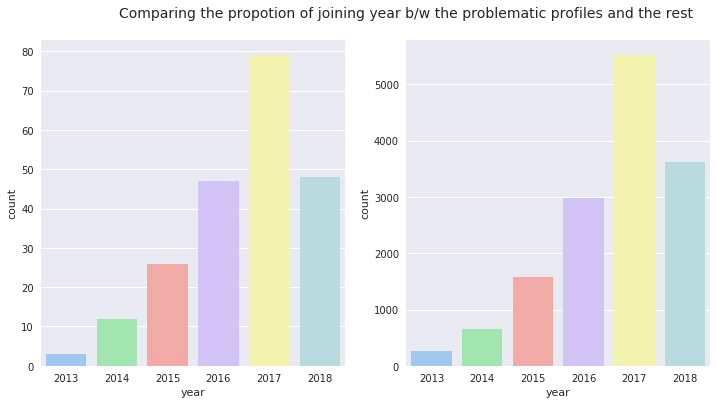

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(x="year", data=problem_df, palette="pastel", ax=ax[0])
sns.countplot(x="year", data=no_problem, palette="pastel", ax=ax[1])
plt.title("""Comparing the propotion of joining year b/w the problematic profiles and the rest\n""", x=0, fontsize=14)

Text(0,1,'Comparing the propotion of genders b/w the problematic profiles and the rest\n')

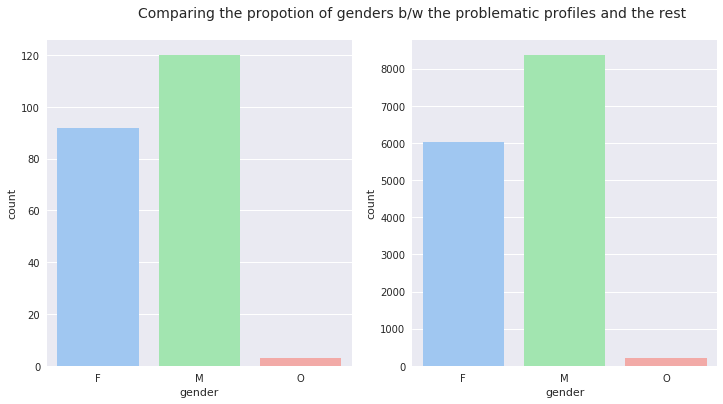

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(x="gender", data=problem_df, palette="pastel", ax=ax[0])
sns.countplot(x="gender", data=no_problem, palette="pastel", ax=ax[1])
plt.title("Comparing the propotion of genders b/w the problematic profiles and the rest\n", x=0, fontsize=14)

### Analysis
Comparing the demographics data using profile.json between customers who used our offers before viewing it and the rest of the customers, there's no significant difference. This indicates that all customers are equally likely to use our offers accidentally.

## Q.3 Which type of offer opted without even noticing the offer recieved?  

In [155]:
#offer ids of the first user-offer interactions that were 'offer received'
offer1 = [lst1[x][1] for x in range(len(lst1))]

#offer ids of the second user-offer interactions that were 'offer completed'
offer2 = [lst2[x][1] for x in range(len(lst2))]

#find the common offer ids and count how many times they appeared
offer_count = Counter(offer1) & Counter(offer2)
offer_count

Counter({'f19421c1d4aa40978ebb69ca19b0e20d': 13,
         'ae264e3637204a6fb9bb56bc8210ddfd': 27,
         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 85,
         '2906b810c7d4411798c6938adc9daaa5': 43,
         'fafdcd668e3743c1bb461111dcafc2a4': 58,
         '2298d6c36e964ae4a3e7e9706d1fb8c2': 36,
         '9b98b8c7a33c4b65b9aebfe6a799e6d9': 35,
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 18})

In [156]:
def counter_to_df(counter):
    #turn the counter object to dataframe
    df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    #rename the columns
    df.rename(columns={'index':'offer id', 0:'count'},inplace=True)
    
    #merge it with the portfolio dataframe so that we can what these offers are
    newdf = portfolio.merge(df, left_on='id', right_on='offer id', how='inner')
    #sort the offers
    newdf.sort_values(by='count', ascending=False, inplace=True)
    return newdf

In [157]:
problemOffers_df = counter_to_df(offer_count)
problemOffers_df

,channels,difficulty,duration,id,offer_type,reward,offer id,count
3,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0b1e1539f2cc45b7b9fa7c272da2e1d7,85
5,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,fafdcd668e3743c1bb461111dcafc2a4,58
7,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,2906b810c7d4411798c6938adc9daaa5,43
4,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,2298d6c36e964ae4a3e7e9706d1fb8c2,36
2,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,35
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,ae264e3637204a6fb9bb56bc8210ddfd,27
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,4d5c57ea9a6940dd891ad53e9dbe8da0,18
6,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,f19421c1d4aa40978ebb69ca19b0e20d,13


In [158]:
offer_bogo_discount = offer_df.loc[(offer_df['offer_type_id']==0) | (offer_df['offer_type_id']==3)]
all_bogo_discount_offers = offer_bogo_discount[offer_bogo_discount['event']=='offer received']
all_offer_count = Counter(all_bogo_discount_offers['offer_id'])
all_offer_count

Counter({'9b98b8c7a33c4b65b9aebfe6a799e6d9': 7677,
         'ae264e3637204a6fb9bb56bc8210ddfd': 7658,
         'f19421c1d4aa40978ebb69ca19b0e20d': 7571,
         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 7668,
         '2906b810c7d4411798c6938adc9daaa5': 7632,
         'fafdcd668e3743c1bb461111dcafc2a4': 7597,
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 7593,
         '2298d6c36e964ae4a3e7e9706d1fb8c2': 7646})

In [159]:
#turn counter to df and merge it with porfolio, sorted
allOffers_df = counter_to_df(all_offer_count)
allOffers_df

,channels,difficulty,duration,id,offer_type,reward,offer id,count
2,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677
3,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,ae264e3637204a6fb9bb56bc8210ddfd,7658
4,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,2298d6c36e964ae4a3e7e9706d1fb8c2,7646
7,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,2906b810c7d4411798c6938adc9daaa5,7632
5,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,fafdcd668e3743c1bb461111dcafc2a4,7597
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,4d5c57ea9a6940dd891ad53e9dbe8da0,7593
6,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,f19421c1d4aa40978ebb69ca19b0e20d,7571


In [160]:
all_offerdf_labels = [x[-3:] for x in allOffers_df['id']]
problem_offerdf_labels = [x[-3:] for x in problemOffers_df['id']]

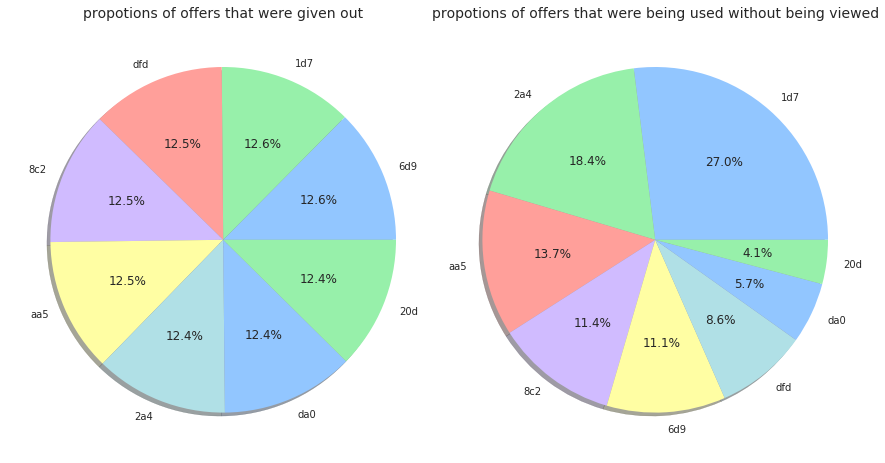

In [161]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1, 2], aspect=1)
ax1.pie(allOffers_df['count'], labels=all_offerdf_labels, autopct='%1.1f%%', shadow=True)
plt.title('propotions of offers that were given out', fontsize=14)

ax2 = fig.add_axes([1, .0, 1, 2], aspect=1)
ax2.pie(problemOffers_df['count'], labels=problem_offerdf_labels, autopct='%1.1f%%', shadow=True)
plt.title('propotions of offers that were being used without being viewed', fontsize=14)
plt.show()

### Analysis
The design of the offer plays a big role, especially the promotion channels and duration.

If an offer is being promoted through web and email, then it has a much greater chance of not being seen being used wihout viewing to link to the duration of the offers. 

Longer duration increase the chance discount offer type also has a greater chance to be used without seeing compare to bogo.

## Modeling

Identify which user is likely to "waste" an offer i.e not using the offer or used the offer without viewing it.

###  Create a new dataframe with the right classification label for modelling

In [162]:
final_df['interacted'] = 1
person_all_offers = final_df.groupby(['person', 'offer_id','event'])['interacted'].max().unstack(fill_value=0)

#if a person (did not use an offer) or (used it without viewing), then the offer is wasted
person_all_offers['wasted'] = np.where((person_all_offers["offer completed"]==1)&(person_all_offers["offer viewed"]==1), 0, 1)
person_all_offers

event                                                              offer completed  \
person                           offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                1   
                                 3f207df678b143eea3cee63160fa8bed                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d                0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2                1   
                                 3f207df678b143eea3cee63160fa8bed                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0                1   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 ae264e3637204a6fb9bb56bc8210ddfd                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2                1   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 3f207df678b143eea3cee63160fa8bed                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
00426fe3ffde4c6b9cb9ad6d077a13ea 0b1e1539f2cc45b7b9fa7c272da2e1d7                0   
                                 2906b810c7d4411798c6938adc9daaa5                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
004b041fbfe44859945daa2c7f79ee64 3f207df678b143eea3cee63160fa8bed                0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
...                                                                            ...   
ffed75d3abc64b488982f50ed12878b5 4d5c57ea9a6940dd891ad53e9dbe8da0                0   
                                 ae264e3637204a6fb9bb56bc8210ddfd                0   
ffede3b700ac41d6a266fa1ba74b4f16 0b1e1539f2cc45b7b9fa7c272da2e1d7                0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0                0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                0   
fff0f0aac6c547b9b263080f09a5586a 3f207df678b143eea3cee63160fa8bed                0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0                0   
fff29fb549084123bd046dbc5ceb4faa 4d5c57ea9a6940dd891ad53e9dbe8da0                1   
                                 ae264e3637204a6fb9bb56bc8210ddfd                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
fff3ba4757bd42088c044ca26d73817a 2906b810c7d4411798c6938adc9daaa5                1   
                                 5a8bc65990b

In [163]:
#creating a new dataframe with only the information that we need to build the model
model_df = person_all_offers['wasted']
model_df.reset_index(level=['person', 'offer_id'])
model_df= model_df.to_frame().reset_index()
model_df.head()

,person,offer_id,wasted
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0


In [164]:
#creating a new dataframe with only the information that we need to build the model
model_df = person_all_offers['wasted']
model_df.reset_index(level=['person', 'offer_id'])
model_df= model_df.to_frame().reset_index()
model_df.head()

,person,offer_id,wasted
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0


In [165]:
#get the information we need from the profile dataframe
model_df = model_df.merge(clean_profile, left_on='person', right_on='id', how='left')
model_df.drop(['id','problem', 'became_member_on'], axis=1, inplace=True)
model_df.head()

,person,offer_id,wasted,age,gender,income,year
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,33.0,M,72000.0,2017
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33.0,M,72000.0,2017
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33.0,M,72000.0,2017
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,33.0,M,72000.0,2017
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,33.0,M,72000.0,2017


In [166]:
#get the information we need from the portfolio dataframe
model_df = model_df.merge(portfolio, left_on='offer_id', right_on='id', how='left')
model_df.drop(['id'], axis=1, inplace=True)
model_df.head()

,person,offer_id,wasted,age,gender,income,year,channels,difficulty,duration,offer_type,reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,33.0,M,72000.0,2017,"[web, email, mobile]",10,7,discount,2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33.0,M,72000.0,2017,"[web, email, mobile]",0,4,informational,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33.0,M,72000.0,2017,"[email, mobile, social]",0,3,informational,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,33.0,M,72000.0,2017,"[web, email, mobile, social]",5,5,bogo,5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,33.0,M,72000.0,2017,"[web, email, mobile, social]",10,10,discount,2


In [167]:
#clean the dataframe by using the function we wrote 
clean_model_df = encode_allcat(model_df, ['gender', 'offer_type', 'offer_id'])
clean_model_df.drop(['gender', 'offer_type', 'offer_id', 'channels', 'year'], axis=1, inplace=True)
clean_model_df.head()

,person,wasted,age,income,difficulty,duration,reward,gender_id,offer_type_id,offer_id_id,year_id,channelTye_id
0,0009655768c64bdeb2e877511632db8f,1,33.0,72000.0,10,7,2,0,0,0,4,2
1,0009655768c64bdeb2e877511632db8f,1,33.0,72000.0,0,4,0,0,1,1,4,2
2,0009655768c64bdeb2e877511632db8f,1,33.0,72000.0,0,3,0,0,1,2,4,1
3,0009655768c64bdeb2e877511632db8f,0,33.0,72000.0,5,5,5,0,2,3,4,3
4,0009655768c64bdeb2e877511632db8f,0,33.0,72000.0,10,10,2,0,0,4,4,3


In [168]:
model_df['wasted'].value_counts()

1    38828
0    24460
Name: wasted, dtype: int64

### Modeling and Evaluation

In [169]:
def model_prep(df):
    #data preperation
    label = df['wasted']
    train = df.iloc[:, 2:].copy()

    #Dividing the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(train, label,test_size=0.20, random_state=1)
    return X_train, X_test, y_train, y_test

In [171]:
X_train, X_test, y_train, y_test = model_prep(clean_model_df)
#dummy model
dummy1 = DummyClassifier(random_state=1).fit(X_train, y_train)
pred_dummy1 = dummy1.predict(X_test)
print("randomly guessing score: {:.2f}".format(dummy1.score(X_test,y_test)))
dummy2 = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
pred_dummy2 = dummy2.predict(X_test)
print("guess all customers will stay score: {:.2f}".format(dummy2.score(X_test,y_test)))

randomly guessing score: 0.53
guess all customers will stay score: 0.62


In [177]:
def LogReg_model(df):
    X_train, X_test, y_train, y_test = model_prep(df)

    # normalizing some numerical values
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()

    X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns=X_test.columns, index=X_test.index)

    grid={"C":np.logspace(-2, 1, 3, 5, 7)}
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg,grid,cv=5, scoring =  ['accuracy', 'precision', 'recall','f1'], refit = 'precision')
    logreg_cv.fit(X_train,y_train)
    y_pred = logreg_cv.predict(X_test)
    
    print("tuned hpyerparameters: (best parameters) ",logreg_cv.best_params_)
    print("precision score: ",logreg_cv.best_score_)
    
    
    display_results(logreg_cv, y_test, y_pred)


def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    confusion_norm = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print(confusion_norm)
    print("Accuracy:", accuracy)

In [175]:
copy_model_df = clean_model_df[clean_model_df['gender_id'].notnull()].copy()
copy_model_df.drop('person', axis=1, inplace=True)
copy_model_df.isnull().sum()

wasted           0
age              0
income           0
difficulty       0
duration         0
reward           0
gender_id        0
offer_type_id    0
offer_id_id      0
year_id          0
channelTye_id    0
dtype: int64

In [178]:
LogReg_model(copy_model_df)

tuned hpyerparameters: (best parameters)  {'C': 7.0}
precision score:  0.750642546228
Labels: [0 1]
Confusion Matrix:
 [[3063 1641]
 [1500 4841]]
[[3063 1641]
 [1500 4841]]
Accuracy: 0.715617926664


### Analysis
False Positive performed worse than False Negative, meaning that the model is more accurate at identifying which offer will be wasted, not which offer will be used. This is essential the money-saving approach for a marketing team.

In [179]:
from sklearn.utils import resample

# Separate majority and minority classes
df_maj = clean_model_df[clean_model_df.wasted==1]
df_min = clean_model_df[clean_model_df.wasted==0]

print("The minority sample size is: {}".format(len(df_min))) #23499

# Downsample majority class
df_maj_ds = resample(df_maj, replace=False,    # sample without replacement
                             n_samples=23499,     # to match minority class
                             random_state=1) # reproducible results
# Combine minority class with downsampled majority class
df_ds = pd.concat([df_maj_ds, df_min])
 
# Display new class counts
df_ds.wasted.value_counts()

The minority sample size is: 24460


0    24460
1    23499
Name: wasted, dtype: int64

In [182]:
copy_df_ds = df_ds[df_ds['gender_id'].notnull()].copy()
copy_df_ds.drop('person', axis=1, inplace=True)
copy_df_ds.isnull().sum()

wasted           0
age              0
income           0
difficulty       0
duration         0
reward           0
gender_id        0
offer_type_id    0
offer_id_id      0
year_id          0
channelTye_id    0
dtype: int64

In [183]:
#result after downsampling the dataset
LogReg_model(copy_df_ds)

tuned hpyerparameters: (best parameters)  {'C': 7.0}
precision score:  0.765467833552
Labels: [0 1]
Confusion Matrix:
 [[3922  764]
 [1426 2417]]
[[3922  764]
 [1426 2417]]
Accuracy: 0.743228983468


## Conclusion
Here I conclude:

* Customers whom joinied ealier, they are a lot less likely to use offers.
* Customers with incomplete profiles are less likely to use offers it seems they are not interested to use app.
* Men are less likely to use offers but they do prefer discount over BOGO, while women used BOGO more.

Suggestions:
To advoid or to improve the situation of using an offer without viewing:
* Need to promote the offer via at least 3 channels to increase exposure
* Eliminate offers that last for 10 days, put maximum for 7 days. 
* There are lots of potential in the discount offer. The completion rate is 78% among those whom viewed the offer. Therefore, if the company can increase the viewing rate of discount offer, there's a great chance to incentive more spending.

Future Improvement:
* Incoporate the data from information offer.
* Improve the model accuracy by fine tuning the model or try tree models.